## Colossus halo density profile demo

Welcome to the halo density profile demo.

In [1]:
from __future__ import print_function 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

As always with colossus, we need to set a cosmology.

In [2]:
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck15');

# Profile basics

The density profile module in colossus is object-oriented: it contains a base class for all density profiles, and classes for specific models that are derived from the base class. Those derived classes need to implement only one function (density), but can overwrite other functions, for example if there are analytical solutions for quantities that would otherwise need to be computed numerically. At first, we don't need to concern ourselves with this architecture though.

In [4]:
from colossus.halo import profile_nfw

To get started, let's create different density profile predictions for a massive cluster halo at z = 0. Profiles can often be initialized by different sets of parameters. For example, an NFW profile can take it's native parameters (central density and scale radius), but can also be initialized using the mass and concentration:

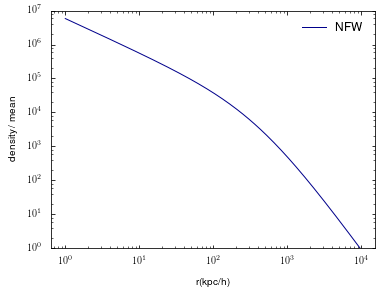

In [5]:
Mvir = 1E15
cvir = 5.0
z = 0.0
p_nfw = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')

r = 10**np.arange(0,4,0.02)
rho_m = cosmo.rho_m(z)
rho_nfw = p_nfw.density(r)

plt.figure()
plt.loglog()
plt.xlabel('r(kpc/h)')
plt.ylabel('density / mean')
plt.plot(r, rho_nfw / rho_m, '-', label = 'NFW');
plt.ylim(1E0, 1E7)
plt.legend();

Let's compute the predictions of other profile models for the same halo:

In [6]:
from colossus.halo import profile_einasto
from colossus.halo import profile_dk14

p_einasto = profile_einasto.EinastoProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')
p_dk14 = profile_dk14.DK14Profile(M = Mvir, c = cvir, z = z, mdef = 'vir')

rho_einasto = p_einasto.density(r)
rho_dk14 = p_dk14.density(r)

Let's add the scale radius and virial radius for the NFW profile for clarity. Spherical overdensity radii and masses can be obtained with the RDelta/MDelta functions. The scale radius is part of the internal parameters of the NFW model, and is thus an entry in the par dictionary that each profile holds:

In [7]:
Rvir_nfw = p_nfw.RDelta(z, 'vir')
print(p_nfw.par)
rs = p_nfw.par['rs']

OrderedDict([('rhos', 1234754.506870338), ('rs', 406.6464224896049)])


The contents of this dictionary will vary between profile models. For example, for the Einasto profile, it also contains the alpha parameter which determines how fast the profile steepens:

In [8]:
print(p_einasto.par)

OrderedDict([('rhos', 319453.0914458966), ('rs', 406.6464224896049), ('alpha', 0.24881825435414046)])


Anyway, let's put all of that into a plot:

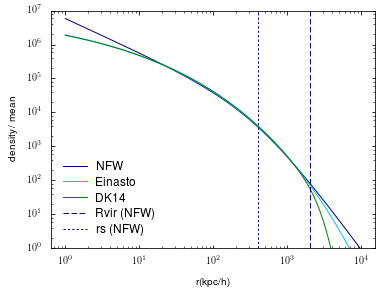

In [9]:
plt.figure()
plt.loglog()
plt.xlabel('r(kpc/h)')
plt.ylabel('density / mean')
plt.plot(r, rho_nfw / rho_m, '-', label = 'NFW');
plt.plot(r, rho_einasto / rho_m, '-', label = 'Einasto');
plt.plot(r, rho_dk14 / rho_m, '-', label = 'DK14');
plt.axvline(Rvir_nfw, ls = '--', label = 'Rvir (NFW)');
plt.axvline(rs, ls = ':', label = 'rs (NFW)');
plt.ylim(1E0, 1E7)
plt.legend();

Of course, we can plot numerous quantities other than density. For example, surface density:

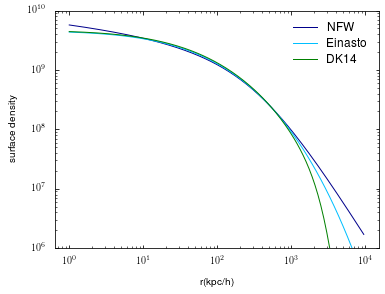

In [11]:
Sigma_nfw = p_nfw.surfaceDensity(r)
Sigma_einasto = p_einasto.surfaceDensity(r)
Sigma_dk14 = p_dk14.surfaceDensity(r)

plt.figure()
plt.loglog()
plt.xlabel('r(kpc/h)')
plt.ylabel('surface density')
plt.plot(r, Sigma_nfw, '-', label = 'NFW');
plt.plot(r, Sigma_einasto, '-', label = 'Einasto');
plt.plot(r, Sigma_dk14, '-', label = 'DK14');
plt.ylim(1E6, 1E10)
plt.legend();

# The outer profile

The differences between profiles in the plot above are mostly apparent at small and large radii. But at large radii, the profile becomes complicated due to non-linear infall and the contribution from other halos (the 2-halo term). In Colossus, such components can be added to the profiles:

In [12]:
from colossus.halo import profile_outer

outer_term_mean = profile_outer.OuterTermMeanDensity(z = z)
p_nfw = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = z, mdef = 'vir', outer_terms = [outer_term_mean])

For the DK14 profile, power-law outer profiles are standard and can be generated with a wrapper function:

In [3]:
p_dk14 = profile_dk14.getDK14ProfileWithOuterTerms(M = Mvir, c = cvir, z = z, mdef = 'vir', outer_term_names = ['pl'])

NameError: name 'profile_dk14' is not defined

Now let's plot a comparison of the profiles with outer terms:

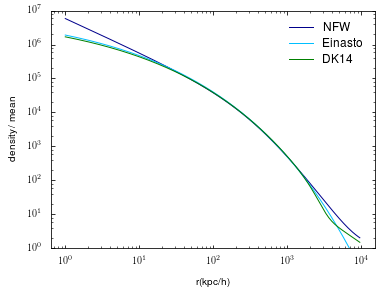

In [15]:
rho_nfw = p_nfw.density(r)
rho_einasto = p_einasto.density(r)
rho_dk14 = p_dk14.density(r)

plt.figure()
plt.loglog()
plt.xlabel('r(kpc/h)')
plt.ylabel('density / mean')
plt.plot(r, rho_nfw / rho_m, '-', label = 'NFW');
plt.plot(r, rho_einasto / rho_m, '-', label = 'Einasto');
plt.plot(r, rho_dk14 / rho_m, '-', label = 'DK14');
plt.ylim(1E0, 1E7)
plt.legend();

Let's add an outer term based on the correlation function to the NFW profile. We compute the bias from the Tinker et al. 2010 bias model:

In [16]:
from colossus.halo import bias
bias = bias.haloBias(Mvir, z, 'vir')
print(bias)
outer_term_xi = profile_outer.OuterTermCorrelationFunction(z = z, bias = bias)
p_nfw = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = z, mdef = 'vir', outer_terms = [outer_term_xi])

5.9954544417


The differences in the outer profiles are more apparent if we plot the slope instead:

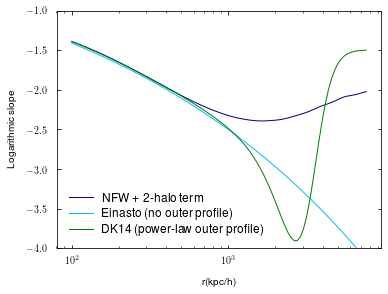

In [17]:
r = 10**np.arange(2,3.9,0.02)
slope_nfw = p_nfw.densityDerivativeLog(r)
slope_einasto = p_einasto.densityDerivativeLog(r)
slope_dk14 = p_dk14.densityDerivativeLog(r)

plt.figure()
plt.xscale('log')
plt.xlabel('r(kpc/h)')
plt.ylabel('Logarithmic slope')
plt.plot(r, slope_nfw, '-', label = 'NFW + 2-halo term');
plt.plot(r, slope_einasto, '-', label = 'Einasto (no outer profile)');
plt.plot(r, slope_dk14, '-', label = 'DK14 (power-law outer profile)');
plt.ylim(-4, -1)
plt.legend();

# Fitting

Let's generate an NFW profile of surface density and some scattered fake data round it:

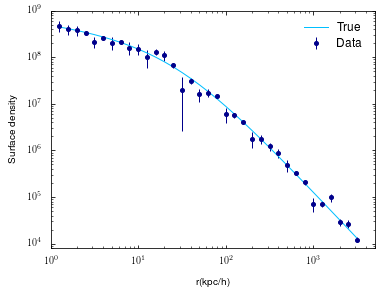

In [18]:
# Generate NFW profile
Mvir = 1E12
cvir = 7.0
p = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = 0.0, mdef = 'vir')

# Generate random scatter around the true surface density profile
r = 10**np.arange(0.1, 3.6, 0.1)
sigma_true = p.surfaceDensity(r)
np.random.seed(155)
sigma_err = np.abs(np.random.normal(0.2, 0.1, (len(r)))) * sigma_true
sigma = sigma_true.copy()
for i in range(len(r)):
    sigma[i] += np.random.normal(0.0, sigma_err[i])

plt.figure()
plt.loglog()
plt.xlim(1E0, 5E3)
plt.ylim(8E3, 1E9)
plt.xlabel('r(kpc/h)')
plt.ylabel('Surface density')
plt.plot(r, sigma_true, '-', color = 'deepskyblue', label = 'True')
plt.legend()
plt.errorbar(r, sigma, yerr = sigma_err, fmt = '.', marker = 'o', ms = 4.0, color = 'darkblue', label = 'Data')
plt.legend();

Now let's generate a bad initial guess of the NFW profile, and recover it by fitting. First, let's see what the true parameters of the NFW profile are. The mask tells the fitter to fit all parameters, whereas False elements are held fixed.

In [19]:
mask = np.array([True, True])
x_true = p.getParameterArray(mask)
print(x_true)

[  2.69611026e+06   2.90461730e+01]


We generate a bad initial guess and set the profile parameters to that guess:

In [20]:
ini_guess = x_true * 1.5
p.setParameterArray(ini_guess, mask = mask)
sigma_ini = p.surfaceDensity(r)

Now fit the profile to the data. The fit() function has many more parameters than discussed here. For example, it can handle covariance matrices, use an MCMC instead of least-squares, and fit density, surface density, enclosed mass and so on. The function's outputs are gathered in one dictionary.

In [21]:
dict = p.fit(r, sigma, 'Sigma', q_err = sigma_err, mask = mask)
sigma_fit = dict['q_fit']

-------------------------------------------------------------------------------------
Profile fit: Varying 2 / 2 parameters.
Could not find analytical derivative function for quantity Sigma.
Found solution in 19 steps. Best-fit parameters:
Parameter       rhos = 2.58e+06 [2.41e+06 .. 2.77e+06]
Parameter         rs = 2.95e+01 [2.86e+01 .. 3.04e+01]
chi2 / Ndof = 35.7 / 33 = 1.08
-------------------------------------------------------------------------------------


The fitter output tells us that we've recovered the input parameters quite exactly. We also get error estimates and a lot of other output. Let's put it all together in a plot:

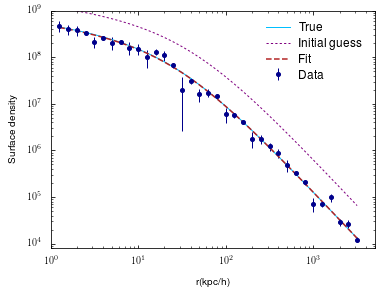

In [22]:
plt.figure()
plt.loglog()
plt.xlim(1E0, 5E3)
plt.ylim(8E3, 1E9)
plt.xlabel('r(kpc/h)')
plt.ylabel('Surface density')
plt.plot(r, sigma_true, '-', color = 'deepskyblue', label = 'True')
plt.plot(r, sigma_ini, ':', color = 'purple', label = 'Initial guess')
plt.plot(r, sigma_fit, '--', color = 'firebrick', lw = 1.5, label = 'Fit')
plt.legend()
plt.errorbar(r, sigma, yerr = sigma_err, fmt = '.', marker = 'o', ms = 4.0, color = 'darkblue', label = 'Data')
plt.legend();

# Creating a new density profile model

What if Colossus doesn't have the density profile model you want? You can still make use of the functionality of the base class by deriving a new profile model from it. For example, let's implement the Hernquist (1990) model:

In [23]:
from colossus.halo import profile_base

class HernquistProfile(profile_base.HaloDensityProfile):

    def __init__(self, rhos, rs):

        self.par_names = ['rhos', 'rs']
        self.opt_names = []
        profile_base.HaloDensityProfile.__init__(self)

        self.par['rhos'] = rhos
        self.par['rs'] = rs

        return

    def densityInner(self, r):

        x = r / self.par['rs']
        density = self.par['rhos'] / x / (1.0 + x)**3

        return density

In the constructor, we had to make the profile class conscious of its internal parameters (central density and scale radius, just as for the NFW profile). This self-awareness is necessary for the fitting routines. Other than that, the only function we had to overwrite was densityInner(). Note that our new constructor does not yet have the ability to convert mass and concentration to central density and scale radius.

In [25]:
Mvir = 1E12
cvir = 7.0

p_nfw = profile_nfw.NFWProfile(M = Mvir, c = cvir, z = z, mdef = 'vir')
rhos = p_nfw.par['rhos']
rs = p_nfw.par['rs']
p_hernquist = HernquistProfile(rhos = rhos, rs = rs)

Now we can use our new profile object in all the same ways demonstrated above, including all the functionality of the base class. For example, we can evaluate the surface density profile even though we never told our new class how to compute that:

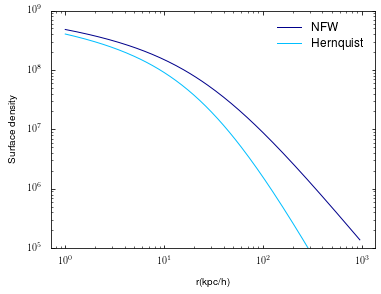

In [26]:
r = 10**np.arange(0,3,0.02)
Sigma_nfw = p_nfw.surfaceDensity(r)
Sigma_hernquist = p_hernquist.surfaceDensity(r)

plt.figure()
plt.loglog()
plt.xlabel('r(kpc/h)')
plt.ylabel('Surface density')
plt.plot(r, Sigma_nfw, '-', label = 'NFW');
plt.plot(r, Sigma_hernquist, '-', label = 'Hernquist');
plt.ylim(1E5, 1E9)
plt.legend();

Note, however, that certain functions might be less accurate or relatively slow. For example, the slope of the density profile would be computed numerically - in the case of the Hernquist profile, it would make sense to overwrite that function using the analytical expression for the slope.